In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import japanize_matplotlib
from scipy.linalg import expm
from scipy.stats import norm
from math import factorial
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import pandas as pd
import tqdm
pd.set_option('display.float_format', lambda x: f'{x:.7f}')


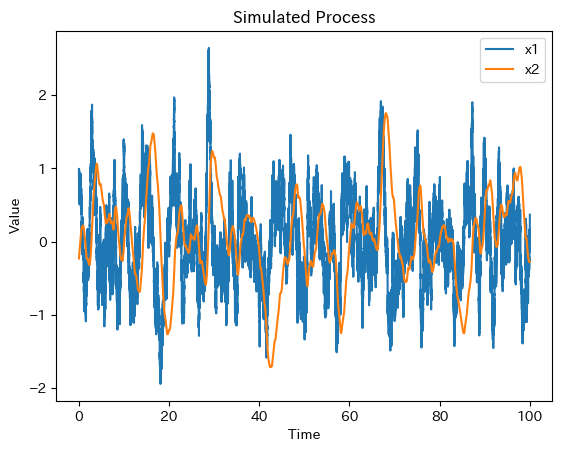

In [2]:
pandas2ri.activate()
yuima = importr("yuima")

def linear_Z(theta, t_max, dt, seed):
    theta1, theta21, theta22, theta3 = theta

    # Pythonの変数をRに渡す
    ro.r.assign("theta1", theta1)
    ro.r.assign("theta21", theta21)
    ro.r.assign("theta22", theta22)
    ro.r.assign("theta3", theta3)

    ro.r('options(warn=-1)')
    ro.r('drift = c("-theta21*x1-theta22*x2", "theta3*x1")')
    ro.r('diffusion = matrix(c("theta1", "0", "0", "0"), 2, 2)')
    ro.r('model = setModel(drift=drift, diffusion=diffusion, state.var=c("x1", "x2"))')

    N = int(t_max / dt)
    ro.r.assign("N", N)
    ro.r.assign("t_max", t_max)
    ro.r('samp = setSampling(Terminal=t_max, n=N)')
    ro.r('yuima = setYuima(model=model, sampling=samp)')
    
    ro.r(f'set.seed({seed})')

    # 初期値を分散 theta_1^2/(2*theta_21) および theta_1^2/(2*theta_21*theta22) の独立な正規分布に設定
    ro.r('xinit = c(rnorm(1, mean=0, sd=sqrt(theta1^2 / (2 * theta21))), '
          'rnorm(1, mean=0, sd=sqrt(theta1^2 / (2 * theta21 * theta22))))')
    
    ro.r('true.par = list(theta1=theta1, theta21=theta21, theta22=theta22, theta3=theta3)')
    ro.r('sim = simulate(yuima, xinit=xinit, true.par=true.par)')
    
    Z_t = ro.r('sim@data@original.data')
    return Z_t.T

# 使用例
theta = [1, 1, 1, 1]
t_max = 100.0  # 最大時間
dt = 0.001  # タイムステップ
seed = 0  # ランダムシード

Z_t = linear_Z(theta, t_max, dt, seed)

# プロット
time_points = np.linspace(0, t_max, int(t_max / dt) + 1)
plt.plot(time_points, Z_t[0], label='x1')
plt.plot(time_points, Z_t[1], label='x2')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Simulated Process')
plt.show()

In [3]:
# 必要な関数の定義
# aを計算する関数
def compute_a(theta, k0):
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]
    a0 = 1
    a1 = -theta21
    A0 = np.array([[0, 1], [-theta22 * theta3, -theta21]])
    An = np.array([np.linalg.matrix_power(A0, n) for n in np.arange(k0 + 1)])
    x0 = np.array([a0, a1])
    xn = np.einsum('ijk,k->ij', An, x0)
    return xn[:, 0]

# bを計算する関数
def compute_b(theta, k0):
    theta21 = theta[1]
    theta22 = theta[2]
    theta3 = theta[3]
    b0 = 0
    b1 = -theta22
    B0 = np.array([[0, 1], [-theta22 * theta3, -theta21]])
    Bn = np.array([np.linalg.matrix_power(B0, n) for n in np.arange(k0 + 1)])
    x0 = np.array([b0, b1])
    xn = np.einsum('ijk,k->ij', Bn, x0)
    return xn[:, 0]

# sを計算する関数
def compute_s(a, theta, k0):
    theta1 = theta[0]
    theta3 = theta[3]
    
    m = np.arange(k0 + 1)
    k = np.arange(k0)
    l = np.arange(k0)
    
    m_grid, k_grid, l_grid = np.meshgrid(m, k, l, indexing='ij')
    valid_mask = (k_grid + l_grid == m_grid)

    m_grid = m_grid * valid_mask
    k_grid = k_grid * valid_mask
    l_grid = l_grid * valid_mask
    
    a_k = a[k_grid] * valid_mask
    a_l = a[l_grid] * valid_mask
    
    fact_11 = 1 / ((m_grid + 1) * scipy.special.factorial(k_grid) * scipy.special.factorial(l_grid))
    fact_12 = 1 / ((m_grid + 2) * scipy.special.factorial(k_grid + 1) * scipy.special.factorial(l_grid))
    fact_22 = 1 / ((m_grid + 3) * scipy.special.factorial(k_grid + 1) * scipy.special.factorial(l_grid + 1))
    
    mat11 = np.einsum('ijk->i', theta1**2 * a_k * a_l * fact_11)
    mat12 = np.einsum('ijk->i', theta1**2 * theta3 * a_k * a_l * fact_12)
    mat22 = np.einsum('ijk->i', theta1**2 * theta3**2 * a_k * a_l * fact_22)
    
    s = np.zeros((k0 + 1, 2, 2))
    s[:, 0, 0] = mat11
    s[:, 0, 1] = mat12
    s[:, 1, 0] = mat12
    s[:, 1, 1] = mat22
    
    return s

# update_2関数
def update_2(theta, Z, k0, h):
    x_current = Z[0][1:]
    y_current = Z[1][1:]
    x_previous = Z[0][:-1]
    y_previous = Z[1][:-1]
    a = compute_a(theta, k0)
    b = compute_b(theta, k0)
    
    matrix = np.array([
        [np.sum(x_previous * x_previous), np.sum(x_previous * y_previous)],
        [np.sum(y_previous * x_previous), np.sum(y_previous * y_previous)]
    ])
    
    correction_x = np.sum([(a[i] * x_previous + b[i] * y_previous) * (h**i) / scipy.special.factorial(i) for i in range(2, k0 + 1)], axis=0)
    
    vector = -np.array([np.sum(x_previous * (x_current - x_previous - correction_x)),
                        np.sum(y_previous * (x_current - x_previous - correction_x))])
    
    return np.linalg.inv(matrix) @ vector / h

# update_1関数
def update_1(theta, Z, k0, h):
    x_current = Z[0][1:]
    y_current = Z[1][1:]
    x_previous = Z[0][:-1]
    y_previous = Z[1][:-1]
    a = compute_a(theta, k0)
    b = compute_b(theta, k0)
    if k0 == 0:
        correction_x = 0
    else:
        correction_x = np.sum([(a[i] * x_previous + b[i] * y_previous) * (h**i) / scipy.special.factorial(i) for i in range(1, k0 + 1)], axis=0)
    
    s = compute_s(a, theta, k0)
    s_11 = s[:, 0, 0]
    correction_term = np.sum([s_11[i] * (h**i) for i in range(1, k0 + 1)])
    
    return np.sqrt(np.mean((x_current - x_previous - correction_x)**2 / h) - correction_term)

# update_3関数
def update_3(theta, Z, k0, h):
    x_current = Z[0][1:]
    y_current = Z[1][1:]
    x_previous = Z[0][:-1]
    y_previous = Z[1][:-1]
    
    a = compute_a(theta, k0)
    b = compute_b(theta, k0)
    
    correction_x = np.sum([(a[i] * x_previous + b[i] * y_previous) * (h**i) / scipy.special.factorial(i) for i in range(1, k0 + 1)], axis=0)
    correction_y = np.sum([theta[3] * (a[i] * x_previous + b[i] * y_previous) * (h**(i + 1)) / scipy.special.factorial(i + 1) for i in range(1, k0 + 1)], axis=0)
    
    numerator1 = np.sum(x_previous * (y_current - y_previous - correction_y))
    numerator2 = np.sum(x_previous * (x_current - x_previous - correction_x))
    denominator = np.sum(x_previous * x_previous)
    
    if denominator == 0:
        raise ValueError("Denominator in calculation is zero, check inputs.")
    
    result = numerator1 / (denominator * h) -  (theta[3] * numerator2) / (denominator * 2)
    
    return result

# update_1_final関数
def update_1_final(theta, Z, k0, h):
    x_current = Z[0][1:]
    y_current = Z[1][1:]
    x_previous = Z[0][:-1]
    y_previous = Z[1][:-1]
    a = compute_a(theta, k0)
    b = compute_b(theta, k0)
    
    correction_x = np.sum([(a[i] * x_previous + b[i] * y_previous) * (h**i) / scipy.special.factorial(i) for i in range(1, k0 + 1)], axis=0)
    correction_y = np.sum([theta[3] * (a[i-1] * x_previous + b[i-1] * y_previous) * (h**i) / scipy.special.factorial(i) for i in range(1, k0 + 2)], axis=0)
    
    vec_x = h**(-1/2) * (x_current - x_previous - correction_x)
    vec_y = h**(-3/2) * (y_current - y_previous - correction_y)
    
    s = compute_s(a, theta, k0)
    S = np.sum([s[i] * h**i for i in range(1, k0 + 1)], axis=0)
    
    term1 = 2 * (np.mean(vec_x * vec_x) - S[0, 0])
    term2 = -6 * (np.mean(vec_x * vec_y) - S[0, 1]) / theta[3]
    term3 = 6 * (np.mean(vec_y * vec_y) - S[1, 1]) / theta[3]**2
    
    return np.sqrt(term1 + term2 + term3)

In [4]:
# メイン処理
theta_initial = [0.5, 0.5, 0.5, 0.5]
t_max = 100.0
dt = 0.001
h = 0.1
n = int(t_max // h)
# 複数のseedでループ
seeds = range(400)
k0_range = range(1, 10)
theta_results = {k: [] for k in k0_range}
scaled_theta_results = {k: [] for k in k0_range}
for seed in tqdm.tqdm(seeds):
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    theta = theta_initial.copy()
    scaled_theta = theta.copy()
    theta_2 = update_2(theta, Z, 1, h)
    theta[1] = theta_2[0]
    theta[2] = theta_2[1]
    theta_1 = update_1(theta, Z, 1, h)
    theta[0] = theta_1
    theta_3 = update_3(theta, Z, 1, h)
    theta[3] = theta_3
    for k0 in k0_range:
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_1 = update_1(theta, Z, k0, h)
        theta[0] = theta_1
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta_1 = update_1_final(theta, Z, k0, h)
        theta[0] = theta_1
        theta_results[k0].append(theta.copy())
        scaled_theta[0] = (theta_1-1) * np.sqrt(n)
        scaled_theta[1] = (theta_2[0]-1) * np.sqrt(n*h)
        scaled_theta[2] = (theta_2[1]-1) * np.sqrt(n*h)
        scaled_theta[3] = (theta_3 -1)* np.sqrt(n/h)
        scaled_theta_results[k0].append(scaled_theta.copy())



theta_results = {k: np.array(theta_results[k]) for k in k0_range}
scaled_theta_results = {k: np.array(scaled_theta_results[k]) for k in k0_range}

# 統計量の計算
theta_means = {k: np.mean(theta_results[k], axis=0) for k in k0_range}
theta_stds = {k: np.std(theta_results[k], axis=0) for k in k0_range}
theta_stds_0 = {k: np.sqrt(np.mean((theta_results[k]-1)**2, axis=0)) for k in k0_range}

# 結果の表示
results = []
for k in k0_range:
    mean_values = theta_means[k]
    std_values = theta_stds[k]
    std_0_values = theta_stds_0[k]
    
    results.append({
        'k0': k,
        'mean_theta1': mean_values[0],
        'mean_theta21': mean_values[1],
        'mean_theta22': mean_values[2],
        'mean_theta3': mean_values[3],
        'std_theta1': std_values[0],
        'std_theta21': std_values[1],
        'std_theta22': std_values[2],
        'std_theta3': std_values[3],
        'std_0_theta1': std_0_values[0],
        'std_0_theta21': std_0_values[1],
        'std_0_theta22': std_0_values[2],
        'std_0_theta3': std_0_values[3]
    })

results_df = pd.DataFrame(results)

# 理論的な標準偏差の計算
theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.4f}"})
print("std_theoretical =", theoretical_std_0_str)

results_df

100%|██████████| 400/400 [02:34<00:00,  2.60it/s]

std_theoretical = [0.0158 0.1414 0.1414 0.0041]


,k0,mean_theta1,mean_theta21,mean_theta22,mean_theta3,std_theta1,std_theta21,std_theta22,std_theta3,std_0_theta1,std_0_theta21,std_0_theta22,std_0_theta3
0,1,0.9752378,1.0138598,0.9792870,0.9993035,0.0157561,0.1387075,0.1349691,0.0044948,0.0293500,0.1393982,0.1365492,0.0045484
1,2,0.9991232,1.0172848,1.0289364,1.0005715,0.0165621,0.1534344,0.1420577,0.0045137,0.0165852,0.1544049,0.1449749,0.0045498
2,3,0.9991749,1.0169164,1.0316172,1.0006771,0.0165539,0.1544523,0.1423961,0.0045184,0.0165745,0.1553759,0.1458640,0.0045689
3,4,0.9991686,1.0167235,1.0316996,1.0006811,0.0165537,0.1545156,0.1423695,0.0045187,0.0165746,0.1554179,0.1458559,0.0045698
4,5,0.9991678,1.0167011,1.0316959,1.0006812,0.0165536,0.1545160,0.1423633,0.0045187,0.0165745,0.1554160,0.1458490,0.0045698
5,6,0.9991678,1.0166991,1.0316946,1.0006812,0.0165536,0.1545155,0.1423624,0.0045187,0.0165745,0.1554152,0.1458479,0.0045698
6,7,0.9991678,1.0166989,1.0316944,1.0006812,0.0165536,0.1545154,0.1423623,0.0045187,0.0165745,0.1554151,0.1458477,0.0045698
7,8,0.9991678,1.0166989,1.0316944,1.0006812,0.0165536,0.1545154,0.1423623,0.0045187,0.0165745,0.1554151,0.1458477,0.0045698
8,9,0.9991678,1.0166989,1.0316944,1.0006812,0.0165536,0.1545154,0.1423623,0.0045187,0.0165745,0.1554151,0.1458477,0.0045698


In [16]:
results_df

,k0,mean_theta1,mean_theta21,mean_theta22,mean_theta3,std_theta1,std_theta21,std_theta22,std_theta3,std_0_theta1,std_0_theta21,std_0_theta22,std_0_theta3
0,1,1.0024927,1.0169207,1.0267153,1.0004857,0.0051609,0.1452979,0.1419796,0.0003751,0.0057313,0.1462799,0.1444712,0.0006137
1,2,1.0050134,1.0170608,1.0319382,1.0004991,0.0051955,0.1468284,0.1427255,0.0003762,0.0072199,0.1478163,0.1462553,0.0006250
2,3,1.0050134,1.0170546,1.0319655,1.0004992,0.0051954,0.1468390,0.1427283,0.0003762,0.0072199,0.1478260,0.1462641,0.0006251
3,4,1.0050134,1.0170544,1.0319655,1.0004992,0.0051954,0.1468390,0.1427283,0.0003762,0.0072199,0.1478261,0.1462640,0.0006251
4,5,1.0050134,1.0170544,1.0319655,1.0004992,0.0051954,0.1468390,0.1427283,0.0003762,0.0072199,0.1478261,0.1462640,0.0006251
5,6,1.0050134,1.0170544,1.0319655,1.0004992,0.0051954,0.1468390,0.1427283,0.0003762,0.0072199,0.1478261,0.1462640,0.0006251
6,7,1.0050134,1.0170544,1.0319655,1.0004992,0.0051954,0.1468390,0.1427283,0.0003762,0.0072199,0.1478261,0.1462640,0.0006251
7,8,1.0050134,1.0170544,1.0319655,1.0004992,0.0051954,0.1468390,0.1427283,0.0003762,0.0072199,0.1478261,0.1462640,0.0006251
8,9,1.0050134,1.0170544,1.0319655,1.0004992,0.0051954,0.1468390,0.1427283,0.0003762,0.0072199,0.1478261,0.1462640,0.0006251


In [21]:
cov_matrix = np.cov(scaled_theta_results[9].T)
#テンソルを計算して平均を求める
tensor = np.einsum('ij,ik->ijk', scaled_theta_results[9], scaled_theta_results[9])
tensor_mean = np.mean(tensor, axis=0)
tensor_mean

array([[0.52121104, 0.15908472, 0.16692538, 0.2410775 ],
       [0.15908472, 2.18503637, 0.10516145, 0.1792787 ],
       [0.16692538, 0.10516145, 2.13910262, 0.16920086],
       [0.2410775 , 0.1792787 , 0.16920086, 0.39067784]])

In [23]:
cov_matrix = np.cov(scaled_theta_results[1].T)
cov_matrix

array([[ 0.26698795,  0.02042966,  0.00498192, -0.01160816],
       [ 0.02042966,  2.11622866,  0.04933984,  0.08406728],
       [ 0.00498192,  0.04933984,  2.02067134,  0.01073295],
       [-0.01160816,  0.08406728,  0.01073295,  0.14107143]])

In [6]:
# メイン処理
theta_initial = [0.5, 0.5, 0.5, 0.5]
t_max = 100.0
dt = 0.001
h = 0.2
n = int(t_max // h)
# 複数のseedでループ
seeds = range(400)
k0_range = range(1, 10)
theta_results = {k: [] for k in k0_range}
scaled_theta_results = {k: [] for k in k0_range}
for seed in tqdm.tqdm(seeds):
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    theta = theta_initial.copy()
    scaled_theta = theta.copy()
    theta_2 = update_2(theta, Z, 1, h)
    theta[1] = theta_2[0]
    theta[2] = theta_2[1]
    theta_1 = update_1(theta, Z, 1, h)
    theta[0] = theta_1
    theta_3 = update_3(theta, Z, 1, h)
    theta[3] = theta_3
    for k0 in k0_range:
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_1 = update_1(theta, Z, k0, h)
        theta[0] = theta_1
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta_1 = update_1_final(theta, Z, k0, h)
        theta[0] = theta_1
        theta_results[k0].append(theta.copy())
        scaled_theta[0] = (theta_1-1) * np.sqrt(n)
        scaled_theta[1] = (theta_2[0]-1) * np.sqrt(n*h)
        scaled_theta[2] = (theta_2[1]-1) * np.sqrt(n*h)
        scaled_theta[3] = (theta_3 -1)* np.sqrt(n/h)
        scaled_theta_results[k0].append(scaled_theta.copy())



theta_results = {k: np.array(theta_results[k]) for k in k0_range}
scaled_theta_results = {k: np.array(scaled_theta_results[k]) for k in k0_range}

# 統計量の計算
theta_means = {k: np.mean(theta_results[k], axis=0) for k in k0_range}
theta_stds = {k: np.std(theta_results[k], axis=0) for k in k0_range}
theta_stds_0 = {k: np.sqrt(np.mean((theta_results[k]-1)**2, axis=0)) for k in k0_range}

# 結果の表示
results = []
for k in k0_range:
    mean_values = theta_means[k]
    std_values = theta_stds[k]
    std_0_values = theta_stds_0[k]
    
    results.append({
        'k0': k,
        'mean_theta1': mean_values[0],
        'mean_theta21': mean_values[1],
        'mean_theta22': mean_values[2],
        'mean_theta3': mean_values[3],
        'std_theta1': std_values[0],
        'std_theta21': std_values[1],
        'std_theta22': std_values[2],
        'std_theta3': std_values[3],
        'std_0_theta1': std_0_values[0],
        'std_0_theta21': std_0_values[1],
        'std_0_theta22': std_0_values[2],
        'std_0_theta3': std_0_values[3]
    })

results_df = pd.DataFrame(results)

# 理論的な標準偏差の計算
theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.4f}"})
print("std_theoretical =", theoretical_std_0_str)

results_df

100%|██████████| 400/400 [02:33<00:00,  2.60it/s]

std_theoretical = [0.0224 0.1414 0.1414 0.0082]


,k0,mean_theta1,mean_theta21,mean_theta22,mean_theta3,std_theta1,std_theta21,std_theta22,std_theta3,std_0_theta1,std_0_theta21,std_0_theta22,std_0_theta3
0,1,0.9537613,1.0087880,0.9275361,0.9952209,0.0220989,0.1312438,0.1288232,0.0090372,0.0512482,0.1315377,0.1478054,0.0102230
1,2,0.9980464,1.0199734,1.0211127,1.0000235,0.0240514,0.1592826,0.1425277,0.0090813,0.0241306,0.1605300,0.1440829,0.0090813
2,3,0.9984216,1.0195414,1.0315328,1.0008112,0.0240615,0.1631705,0.1441257,0.0091183,0.0241132,0.1643365,0.1475349,0.0091543
3,4,0.9983485,1.0182680,1.0323021,1.0008637,0.0240608,0.1637196,0.1440301,0.0091229,0.0241174,0.1647356,0.1476079,0.0091637
4,5,0.9983292,1.0179616,1.0322894,1.0008674,0.0240592,0.1637538,0.1439606,0.0091235,0.0241172,0.1647359,0.1475373,0.0091647
5,6,0.9983259,1.0179038,1.0322615,1.0008676,0.0240589,0.1637438,0.1439388,0.0091236,0.0241170,0.1647197,0.1475100,0.0091647
6,7,0.9983254,1.0178946,1.0322534,1.0008676,0.0240588,0.1637394,0.1439339,0.0091236,0.0241170,0.1647143,0.1475034,0.0091647
7,8,0.9983254,1.0178934,1.0322517,1.0008676,0.0240587,0.1637383,0.1439330,0.0091236,0.0241170,0.1647131,0.1475021,0.0091647
8,9,0.9983253,1.0178933,1.0322514,1.0008676,0.0240587,0.1637381,0.1439329,0.0091236,0.0241170,0.1647129,0.1475019,0.0091647


In [9]:
# メイン処理
theta_initial = [0.5, 0.5, 0.5, 0.5]
t_max = 100.0
dt = 0.001
h = 0.5
n = int(t_max // h)
# 複数のseedでループ
seeds = range(400)
k0_range = range(1, 11)
theta_results = {k: [] for k in k0_range}
scaled_theta_results = {k: [] for k in k0_range}
for seed in tqdm.tqdm(seeds):
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    theta = theta_initial.copy()
    scaled_theta = theta.copy()
    theta_2 = update_2(theta, Z, 1, h)
    theta[1] = theta_2[0]
    theta[2] = theta_2[1]
    theta_1 = update_1(theta, Z, 1, h)
    theta[0] = theta_1
    theta_3 = update_3(theta, Z, 1, h)
    theta[3] = theta_3
    for k0 in k0_range:
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_1 = update_1(theta, Z, k0, h)
        theta[0] = theta_1
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta_1 = update_1_final(theta, Z, k0, h)
        theta[0] = theta_1
        theta_results[k0].append(theta.copy())
        scaled_theta[0] = (theta_1-1) * np.sqrt(n)
        scaled_theta[1] = (theta_2[0]-1) * np.sqrt(n*h)
        scaled_theta[2] = (theta_2[1]-1) * np.sqrt(n*h)
        scaled_theta[3] = (theta_3 -1)* np.sqrt(n/h)
        scaled_theta_results[k0].append(scaled_theta.copy())



theta_results = {k: np.array(theta_results[k]) for k in k0_range}
scaled_theta_results = {k: np.array(scaled_theta_results[k]) for k in k0_range}

# 統計量の計算
theta_means = {k: np.mean(theta_results[k], axis=0) for k in k0_range}
theta_stds = {k: np.std(theta_results[k], axis=0) for k in k0_range}
theta_stds_0 = {k: np.sqrt(np.mean((theta_results[k]-1)**2, axis=0)) for k in k0_range}

# 結果の表示
results = []
for k in k0_range:
    mean_values = theta_means[k]
    std_values = theta_stds[k]
    std_0_values = theta_stds_0[k]
    
    results.append({
        'k0': k,
        'mean_theta1': mean_values[0],
        'mean_theta21': mean_values[1],
        'mean_theta22': mean_values[2],
        'mean_theta3': mean_values[3],
        'std_theta1': std_values[0],
        'std_theta21': std_values[1],
        'std_theta22': std_values[2],
        'std_theta3': std_values[3],
        'std_0_theta1': std_0_values[0],
        'std_0_theta21': std_0_values[1],
        'std_0_theta22': std_0_values[2],
        'std_0_theta3': std_0_values[3]
    })

results_df = pd.DataFrame(results)

# 理論的な標準偏差の計算
theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.4f}"})
print("std_theoretical =", theoretical_std_0_str)

results_df

100%|██████████| 400/400 [02:34<00:00,  2.59it/s]

std_theoretical = [0.0354 0.1414 0.1414 0.0204]


,k0,mean_theta1,mean_theta21,mean_theta22,mean_theta3,std_theta1,std_theta21,std_theta22,std_theta3,std_0_theta1,std_0_theta21,std_0_theta22,std_0_theta3
0,1,0.9148509,0.9730582,0.7744926,0.9641965,0.0380951,0.1090106,0.1083575,0.0264472,0.0932824,0.1122906,0.2501898,0.0445122
1,2,0.9954201,1.0260843,0.9630023,0.9893679,0.0405305,0.1653370,0.1372519,0.0271788,0.0407885,0.1673819,0.1421511,0.0291844
2,3,0.9983733,1.0379890,1.0172539,0.9994418,0.0409775,0.1833133,0.1483056,0.0283006,0.0410098,0.1872083,0.1493059,0.0283061
3,4,0.9976258,1.0288423,1.0307150,1.0007586,0.0409878,0.1902628,0.1504204,0.0286561,0.0410565,0.1924365,0.1535243,0.0286662
4,5,0.9968086,1.0225673,1.0336025,1.0008620,0.0409153,0.1922884,0.1507022,0.0287853,0.0410395,0.1936081,0.1544030,0.0287982
5,6,0.9964283,1.0193542,1.0333736,1.0007953,0.0408965,0.1923033,0.1503410,0.0288080,0.0410522,0.1932748,0.1540007,0.0288190
6,7,0.9962912,1.0179465,1.0327599,1.0007373,0.0408791,0.1918991,0.1499715,0.0288029,0.0410470,0.1927365,0.1535078,0.0288123
7,8,0.9962369,1.0174010,1.0323424,1.0007077,0.0408681,0.1915585,0.1497351,0.0287947,0.0410410,0.1923472,0.1531883,0.0288034
8,9,0.9962177,1.0172112,1.0321270,1.0006950,0.0408625,0.1913553,0.1496105,0.0287890,0.0410372,0.1921277,0.1530211,0.0287974
9,10,0.9962116,1.0171526,1.0320306,1.0006903,0.0408600,0.1912529,0.1495522,0.0287858,0.0410352,0.1920205,0.1529439,0.0287940


In [8]:
# メイン処理
theta_initial = [0.5, 0.5, 0.5, 0.5]
t_max = 100.0
dt = 0.001
h = 0.9
n = int(t_max // h)
# 複数のseedでループ
seeds = range(400)
k0_range = range(1, 11)
theta_results = {k: [] for k in k0_range}
scaled_theta_results = {k: [] for k in k0_range}
for seed in tqdm.tqdm(seeds):
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    theta = theta_initial.copy()
    scaled_theta = theta.copy()
    theta_2 = update_2(theta, Z, 1, h)
    theta[1] = theta_2[0]
    theta[2] = theta_2[1]
    theta_1 = update_1(theta, Z, 1, h)
    theta[0] = theta_1
    theta_3 = update_3(theta, Z, 1, h)
    theta[3] = theta_3
    for k0 in k0_range:
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_1 = update_1(theta, Z, k0, h)
        theta[0] = theta_1
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta_1 = update_1_final(theta, Z, k0, h)
        theta[0] = theta_1
        theta_results[k0].append(theta.copy())
        scaled_theta[0] = (theta_1-1) * np.sqrt(n)
        scaled_theta[1] = (theta_2[0]-1) * np.sqrt(n*h)
        scaled_theta[2] = (theta_2[1]-1) * np.sqrt(n*h)
        scaled_theta[3] = (theta_3 -1)* np.sqrt(n/h)
        scaled_theta_results[k0].append(scaled_theta.copy())



theta_results = {k: np.array(theta_results[k]) for k in k0_range}
scaled_theta_results = {k: np.array(scaled_theta_results[k]) for k in k0_range}

# 統計量の計算
theta_means = {k: np.mean(theta_results[k], axis=0) for k in k0_range}
theta_stds = {k: np.std(theta_results[k], axis=0) for k in k0_range}
theta_stds_0 = {k: np.sqrt(np.mean((theta_results[k]-1)**2, axis=0)) for k in k0_range}

# 結果の表示
results = []
for k in k0_range:
    mean_values = theta_means[k]
    std_values = theta_stds[k]
    std_0_values = theta_stds_0[k]
    
    results.append({
        'k0': k,
        'mean_theta1': mean_values[0],
        'mean_theta21': mean_values[1],
        'mean_theta22': mean_values[2],
        'mean_theta3': mean_values[3],
        'std_theta1': std_values[0],
        'std_theta21': std_values[1],
        'std_theta22': std_values[2],
        'std_theta3': std_values[3],
        'std_0_theta1': std_0_values[0],
        'std_0_theta21': std_0_values[1],
        'std_0_theta22': std_0_values[2],
        'std_0_theta3': std_0_values[3]
    })

results_df = pd.DataFrame(results)

# 理論的な標準偏差の計算
theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.4f}"})
print("std_theoretical =", theoretical_std_0_str)

results_df

100%|██████████| 400/400 [02:35<00:00,  2.57it/s]

std_theoretical = [0.0474 0.1414 0.1414 0.0367]


,k0,mean_theta1,mean_theta21,mean_theta22,mean_theta3,std_theta1,std_theta21,std_theta22,std_theta3,std_0_theta1,std_0_theta21,std_0_theta22,std_0_theta3
0,1,0.9348708,0.8991711,0.5891164,0.8847446,0.0746665,0.0866659,0.0844411,0.0576004,0.0990803,0.1329565,0.4194706,0.1288473
1,2,1.0111698,1.0316019,0.8276294,0.9502298,0.0671020,0.1615117,0.1223243,0.0620222,0.0680253,0.1645743,0.2113643,0.0795225
2,3,1.0191862,1.0962123,0.9413544,0.9942715,0.0702705,0.1944653,0.1495274,0.0702134,0.0728427,0.2169644,0.1606168,0.0704467
3,4,1.0166053,1.0924310,0.9991754,1.0059977,0.0654369,0.2206877,0.1613816,0.0735232,0.0675109,0.2392625,0.1613837,0.0737674
4,5,1.0104886,1.0786878,1.0340737,1.0099959,0.0636145,0.2397037,0.1717694,0.0761199,0.0644734,0.2522888,0.1751164,0.0767734
5,6,1.0059491,1.0623567,1.0497967,1.0105359,0.0637529,0.2499774,0.1777723,0.0777423,0.0640299,0.2576375,0.1846150,0.0784530
6,7,1.0043297,1.0476112,1.0547431,1.0095050,0.0638303,0.2543057,0.1804089,0.0785058,0.0639770,0.2587243,0.1885317,0.0790791
7,8,1.0029813,1.0363245,1.0542615,1.0081442,0.0638240,0.2549075,0.1807430,0.0787741,0.0638935,0.2574826,0.1887123,0.0791940
8,9,1.0021401,1.0285263,1.0515615,1.0069340,0.0638666,0.2535094,0.1797053,0.0787890,0.0639024,0.2551093,0.1869561,0.0790936
9,10,1.0016420,1.0235670,1.0484142,1.0060180,0.0638861,0.2513370,0.1780754,0.0787134,0.0639072,0.2524394,0.1845394,0.0789431


In [28]:
seeds = range(1)
k0_range = range(1, 21)
theta_results = {k: [] for k in k0_range}

for seed in seeds:
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    
    theta = theta_initial.copy()
    for k0 in k0_range:
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_1 = update_1(theta, Z, k0, h)
        theta[0] = theta_1
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta_1_ = update_1_final(theta, Z, k0, h)
        theta[0] = theta_1_
        print(theta)

[0.9950912232564194, 0.9255855082903209, 0.9592971595886437, 0.9826110728236418]
[1.0002067887153672, 0.92129013439117, 1.0036927370416096, 1.0046748984616087]
[0.9998550752750308, 0.9193984749635631, 1.0057987683892071, 1.0057083154253406]
[0.9998292707226684, 0.9190434603935962, 1.0057669560928961, 1.005753377158737]
[0.9998275967012202, 0.919010260320774, 1.005749433726318, 1.005755363020173]
[0.9998274996658105, 0.919007990417793, 1.005747036101086, 1.0057554515619869]
[0.9998274955810161, 0.9190078928878133, 1.0057468142177566, 1.0057554555733108]
[0.9998274955223576, 0.9190078943063864, 1.0057467990151685, 1.0057554557680248]
[0.9998274955381304, 0.9190078951442626, 1.0057467983559156, 1.0057554557785813]
[0.9998274955405384, 0.9190078952511052, 1.0057467983639972, 1.0057554557792125]
[0.99982749554076, 0.9190078952604109, 1.0057467983694306, 1.005755455779251]
[0.9998274955407747, 0.9190078952609989, 1.00574679837013, 1.005755455779253]
[0.9998274955407753, 0.9190078952610192, 1

In [41]:
# メイン処理
theta_initial = [0.5, 0.5, 0.5, 0.5]
t_max = 100.0
dt = 0.001
h = 0.01

# 複数のseedでループ
seeds = range(1,400)
k0_range = range(1, 3)
theta_results = {k: [] for k in k0_range}

for seed in seeds:
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    
    theta = theta_initial.copy()
    for k0 in k0_range:
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_1 = update_1(theta, Z, k0, h)
        theta[0] = theta_1
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta_1_ = update_1_final(theta, Z, k0, h)
        theta[0] = theta_1_
        theta_results[k0].append(theta.copy())

theta_results = {k: np.array(theta_results[k]) for k in k0_range}

# 統計量の計算
theta_means = {k: np.mean(theta_results[k], axis=0) for k in k0_range}
theta_stds = {k: np.std(theta_results[k], axis=0) for k in k0_range}
theta_stds_0 = {k: np.sqrt(np.mean((theta_results[k]-1)**2, axis=0)) for k in k0_range}

# 結果の表示
results = []
for k in k0_range:
    mean_values = theta_means[k]
    std_values = theta_stds[k]
    std_0_values = theta_stds_0[k]
    
    results.append({
        'k0': k,
        'mean_theta1': mean_values[0],
        'mean_theta21': mean_values[1],
        'mean_theta22': mean_values[2],
        'mean_theta3': mean_values[3],
        'std_theta1': std_values[0],
        'std_theta21': std_values[1],
        'std_theta22': std_values[2],
        'std_theta3': std_values[3],
        'std_0_theta1': std_0_values[0],
        'std_0_theta21': std_0_values[1],
        'std_0_theta22': std_0_values[2],
        'std_0_theta3': std_0_values[3]
    })

results_df = pd.DataFrame(results)

# 理論的な標準偏差の計算
theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.9f}"})
print("std_theoretical =", theoretical_std_0_str)

results_df

std_theoretical = [0.005000000 0.141421356 0.141421356 0.000408248]


,k0,mean_theta1,mean_theta21,mean_theta22,mean_theta3,std_theta1,std_theta21,std_theta22,std_theta3,std_0_theta1,std_0_theta21,std_0_theta22,std_0_theta3
0,1,1.0045561,1.0336668,1.0153801,0.9979519,0.0054211,0.1464820,0.1494610,0.0005206,0.0070814,0.1503012,0.1502503,0.0021132
1,2,1.0052323,1.0340499,1.0206222,1.0005207,0.0054327,0.1480878,0.1502005,0.0004291,0.0075426,0.1519519,0.1516096,0.0006747


In [37]:
results_df

,k0,mean_theta1,mean_theta21,mean_theta22,mean_theta3,std_theta1,std_theta21,std_theta22,std_theta3,std_0_theta1,std_0_theta21,std_0_theta22,std_0_theta3
0,1,1.0043553,1.0169207,1.0267153,0.9979529,0.0051803,0.1452979,0.1419796,0.0004764,0.0067679,0.1462799,0.1444712,0.0021018
1,2,1.0050183,1.0170738,1.0319382,1.0004859,0.0051956,0.1468303,0.1427255,0.0003755,0.0072234,0.1478196,0.1462553,0.0006141


In [38]:
0.0004764**2

2.2695695999999997e-07

In [40]:
0.0003757**2

1.4115049000000002e-07

In [39]:
1/6

0.16666666666666666

In [35]:
# メイン処理
theta_initial = [0.5, 0.5, 0.5, 0.5]
t_max = 100.0
dt = 0.001
h = 0.01
n = t_max / h
# 複数のseedでループ
seeds = range(400)
k0_range = range(1, 3)
theta_results = {k: [] for k in k0_range}

for seed in seeds:
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    
    theta = theta_initial.copy()
    for k0 in k0_range:
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_1 = update_1(theta, Z, k0, h)
        theta[0] = theta_1
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta_1_ = update_1_final(theta, Z, k0, h)
        theta[0] = theta_1_
        theta_results[k0].append(theta.copy())

theta_results = {k: np.array(theta_results[k]) for k in k0_range}

# 補正された結果の計算
corrected_theta_results = {}
for k in k0_range:
    corrected_theta = theta_results[k].copy()
    corrected_theta[:, 0] *= np.sqrt(n)
    corrected_theta[:, 1] *= np.sqrt(n * h)
    corrected_theta[:, 2] *= np.sqrt(n * h)
    corrected_theta[:, 3] *= np.sqrt(n / h)
    corrected_theta_results[k] = corrected_theta

# 補正された統計量の計算
corrected_theta_means = {k: np.mean(corrected_theta_results[k], axis=0) for k in k0_range}
corrected_theta_stds = {k: np.std(corrected_theta_results[k], axis=0) for k in k0_range}

# 結果の表示
corrected_results = []
for k in k0_range:
    mean_values = corrected_theta_means[k]
    std_values = corrected_theta_stds[k]
    
    corrected_results.append({
        'k0': k,
        'mean_theta1': mean_values[0],
        'mean_theta21': mean_values[1],
        'mean_theta22': mean_values[2],
        'mean_theta3': mean_values[3],
        'std_theta1': std_values[0],
        'std_theta21': std_values[1],
        'std_theta22': std_values[2],
        'std_theta3': std_values[3]
    })

corrected_results_df = pd.DataFrame(corrected_results)

# 理論的な標準偏差の計算
theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.4f}"})
print("std_theoretical =", theoretical_std_0_str)

# 結果の表示
pd.set_option('display.float_format', '{:.4f}'.format)
print(corrected_results_df)

std_theoretical = [0.0050 0.1414 0.1414 0.0004]
   k0  mean_theta1  mean_theta21  mean_theta22  mean_theta3  std_theta1  \
0   1     100.4355       10.1692       10.2672     997.9529      0.5180   
1   2     100.5018       10.1707       10.3194    1000.4859      0.5196   

   std_theta21  std_theta22  std_theta3  
0       1.4530       1.4198      0.4764  
1       1.4683       1.4273      0.3755  


In [ ]:
# メイン処理
theta_initial = [0.5, 0.5, 0.5, 0.5]
t_max = 100.0
dt = 0.001
h = 0.01
n = t_max / h
# 複数のseedでループ
seeds = range(400)
k0_range = range(1, 3)
theta_results = {k: [] for k in k0_range}

for seed in seeds:
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    
    theta = theta_initial.copy()
    for k0 in k0_range:
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_1 = update_1(theta, Z, k0, h)
        theta[0] = theta_1
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta_1_ = update_1_final(theta, Z, k0, h)
        theta[0] = theta_1_
        theta_results[k0].append(theta.copy())

theta_results = {k: np.array(theta_results[k]) for k in k0_range}

# 統計量の計算
theta_means = {k: np.mean(theta_results[k], axis=0) for k in k0_range}
theta_stds = {k: np.std(theta_results[k], axis=0) for k in k0_range}
theta_stds_0 = {k: np.sqrt(np.mean((theta_results[k]-1)**2, axis=0)) for k in k0_range}

# 結果の表示
results = []
for k in k0_range:
    mean_values = theta_means[k]
    std_values = theta_stds[k]
    std_0_values = theta_stds_0[k]
    
    results.append({
        'k0': k,
        'mean_theta1': mean_values[0],
        'mean_theta21': mean_values[1],
        'mean_theta22': mean_values[2],
        'mean_theta3': mean_values[3],
        'std_theta1': std_values[0],
        'std_theta21': std_values[1],
        'std_theta22': std_values[2],
        'std_theta3': std_values[3],
        'std_0_theta1': std_0_values[0],
        'std_0_theta21': std_0_values[1],
        'std_0_theta22': std_0_values[2],
        'std_0_theta3': std_0_values[3]
    })

results_df = pd.DataFrame(results)

# 理論的な標準偏差の計算
theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.4f}"})
print("std_theoretical =", theoretical_std_0_str)

results_df

In [31]:
# メイン処理
theta_initial = [0.5, 0.5, 0.5, 0.5]
t_max = 1000.0
dt = 0.01
h = 0.1

# 複数のseedでループ
seeds = range(300)
k0_range = range(1, 21)
theta_results = {k: [] for k in k0_range}

for seed in seeds:
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    
    theta = theta_initial.copy()
    for k0 in k0_range:
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_1 = update_1(theta, Z, k0, h)
        theta[0] = theta_1
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta_1_ = update_1_final(theta, Z, k0, h)
        theta[0] = theta_1_
        theta_results[k0].append(theta.copy())

theta_results = {k: np.array(theta_results[k]) for k in k0_range}

# 統計量の計算
theta_means = {k: np.mean(theta_results[k], axis=0) for k in k0_range}
theta_stds = {k: np.std(theta_results[k], axis=0) for k in k0_range}
theta_stds_0 = {k: np.sqrt(np.mean((theta_results[k]-1)**2, axis=0)) for k in k0_range}

# 結果の表示
results = []
for k in k0_range:
    mean_values = theta_means[k]
    std_values = theta_stds[k]
    std_0_values = theta_stds_0[k]
    
    results.append({
        'k0': k,
        'mean_theta1': mean_values[0],
        'mean_theta21': mean_values[1],
        'mean_theta22': mean_values[2],
        'mean_theta3': mean_values[3],
        'std_theta1': std_values[0],
        'std_theta21': std_values[1],
        'std_theta22': std_values[2],
        'std_theta3': std_values[3],
        'std_0_theta1': std_0_values[0],
        'std_0_theta21': std_0_values[1],
        'std_0_theta22': std_0_values[2],
        'std_0_theta3': std_0_values[3]
    })

results_df = pd.DataFrame(results)

# 理論的な標準偏差の計算
theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.4f}"})
print("std_theoretical =", theoretical_std_0_str)

results_df

std_theoretical = [0.0050 0.0447 0.0447 0.0013]


,k0,mean_theta1,mean_theta21,mean_theta22,mean_theta3,std_theta1,std_theta21,std_theta22,std_theta3,std_0_theta1,std_0_theta21,std_0_theta22,std_0_theta3
0,1,1.0023,0.9991,0.9559,0.9800,0.0052,0.0414,0.0404,0.0016,0.0057,0.0414,0.0598,0.0201
1,2,1.0083,1.0022,1.0037,1.0039,0.0053,0.0456,0.0426,0.0014,0.0098,0.0457,0.0427,0.0041
2,3,1.0078,1.0007,1.0062,1.0051,0.0053,0.0458,0.0427,0.0014,0.0094,0.0458,0.0431,0.0053
3,4,1.0078,1.0003,1.0063,1.0052,0.0053,0.0458,0.0427,0.0014,0.0094,0.0458,0.0431,0.0054
4,5,1.0078,1.0003,1.0062,1.0052,0.0053,0.0458,0.0427,0.0014,0.0094,0.0458,0.0431,0.0054
5,6,1.0078,1.0003,1.0062,1.0052,0.0053,0.0458,0.0427,0.0014,0.0094,0.0458,0.0431,0.0054
6,7,1.0078,1.0003,1.0062,1.0052,0.0053,0.0458,0.0427,0.0014,0.0094,0.0458,0.0431,0.0054
7,8,1.0078,1.0003,1.0062,1.0052,0.0053,0.0458,0.0427,0.0014,0.0094,0.0458,0.0431,0.0054
8,9,1.0078,1.0003,1.0062,1.0052,0.0053,0.0458,0.0427,0.0014,0.0094,0.0458,0.0431,0.0054
9,10,1.0078,1.0003,1.0062,1.0052,0.0053,0.0458,0.0427,0.0014,0.0094,0.0458,0.0431,0.0054


In [21]:
# メイン処理
theta_initial = [0.5, 0.5, 0.5, 0.5]
t_max = 300.0
dt = 0.01
h = 0.1

# 複数のseedでループ
seeds = range(300)
k0_range = range(1, 21)
theta_results = {k: [] for k in k0_range}

for seed in seeds:
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    
    theta = theta_initial.copy()
    for k0 in k0_range:
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_1 = update_1(theta, Z, k0, h)
        theta[0] = theta_1
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta_1_ = update_1_final(theta, Z, k0, h)
        theta[0] = theta_1_
        theta_results[k0].append(theta.copy())

theta_results = {k: np.array(theta_results[k]) for k in k0_range}

# 統計量の計算
theta_means = {k: np.mean(theta_results[k], axis=0) for k in k0_range}
theta_stds = {k: np.std(theta_results[k], axis=0) for k in k0_range}
theta_stds_0 = {k: np.sqrt(np.mean((theta_results[k]-1)**2, axis=0)) for k in k0_range}

# 結果の表示
results = []
for k in k0_range:
    mean_values = theta_means[k]
    std_values = theta_stds[k]
    std_0_values = theta_stds_0[k]
    
    results.append({
        'k0': k,
        'mean_theta1': mean_values[0],
        'mean_theta21': mean_values[1],
        'mean_theta22': mean_values[2],
        'mean_theta3': mean_values[3],
        'std_theta1': std_values[0],
        'std_theta21': std_values[1],
        'std_theta22': std_values[2],
        'std_theta3': std_values[3],
        'std_0_theta1': std_0_values[0],
        'std_0_theta21': std_0_values[1],
        'std_0_theta22': std_0_values[2],
        'std_0_theta3': std_0_values[3]
    })

results_df = pd.DataFrame(results)

# 理論的な標準偏差の計算
theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.4f}"})
print("std_theoretical =", theoretical_std_0_str)

results_df

std_theoretical = [0.0091 0.0816 0.0816 0.0024]


,k0,mean_theta1,mean_theta21,mean_theta22,mean_theta3,std_theta1,std_theta21,std_theta22,std_theta3,std_0_theta1,std_0_theta21,std_0_theta22,std_0_theta3
0,1,1.0019,1.0070,0.9568,0.9799,0.0094,0.0703,0.0748,0.0027,0.0096,0.0707,0.0864,0.0203
1,2,1.0079,1.0111,1.0050,1.0040,0.0095,0.0776,0.0786,0.0024,0.0124,0.0784,0.0788,0.0046
2,3,1.0074,1.0096,1.0076,1.0052,0.0095,0.0780,0.0788,0.0024,0.0121,0.0786,0.0792,0.0057
3,4,1.0074,1.0093,1.0076,1.0053,0.0095,0.0780,0.0788,0.0024,0.0121,0.0785,0.0791,0.0058
4,5,1.0074,1.0092,1.0076,1.0053,0.0095,0.0780,0.0788,0.0024,0.0121,0.0785,0.0791,0.0058
5,6,1.0074,1.0092,1.0076,1.0053,0.0095,0.0780,0.0788,0.0024,0.0121,0.0785,0.0791,0.0058
6,7,1.0074,1.0092,1.0076,1.0053,0.0095,0.0780,0.0788,0.0024,0.0121,0.0785,0.0791,0.0058
7,8,1.0074,1.0092,1.0076,1.0053,0.0095,0.0780,0.0788,0.0024,0.0121,0.0785,0.0791,0.0058
8,9,1.0074,1.0092,1.0076,1.0053,0.0095,0.0780,0.0788,0.0024,0.0121,0.0785,0.0791,0.0058
9,10,1.0074,1.0092,1.0076,1.0053,0.0095,0.0780,0.0788,0.0024,0.0121,0.0785,0.0791,0.0058


In [20]:
# メイン処理
theta_initial = [0.5, 0.5, 0.5, 0.5]
t_max = 300.0
dt = 0.01
h = 0.5

# 複数のseedでループ
seeds = range(300)
k0_range = range(1, 21)
theta_results = {k: [] for k in k0_range}

for seed in seeds:
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    
    theta = theta_initial.copy()
    for k0 in k0_range:
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_1 = update_1(theta, Z, k0, h)
        theta[0] = theta_1
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta_1_ = update_1_final(theta, Z, k0, h)
        theta[0] = theta_1_
        theta_results[k0].append(theta.copy())

theta_results = {k: np.array(theta_results[k]) for k in k0_range}

# 統計量の計算
theta_means = {k: np.mean(theta_results[k], axis=0) for k in k0_range}
theta_stds = {k: np.std(theta_results[k], axis=0) for k in k0_range}
theta_stds_0 = {k: np.sqrt(np.mean((theta_results[k]-1)**2, axis=0)) for k in k0_range}

# 結果の表示
results = []
for k in k0_range:
    mean_values = theta_means[k]
    std_values = theta_stds[k]
    std_0_values = theta_stds_0[k]
    
    results.append({
        'k0': k,
        'mean_theta1': mean_values[0],
        'mean_theta21': mean_values[1],
        'mean_theta22': mean_values[2],
        'mean_theta3': mean_values[3],
        'std_theta1': std_values[0],
        'std_theta21': std_values[1],
        'std_theta22': std_values[2],
        'std_theta3': std_values[3],
        'std_0_theta1': std_0_values[0],
        'std_0_theta21': std_0_values[1],
        'std_0_theta22': std_0_values[2],
        'std_0_theta3': std_0_values[3]
    })

results_df = pd.DataFrame(results)

# 理論的な標準偏差の計算
theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.4f}"})
print("std_theoretical =", theoretical_std_0_str)

results_df

std_theoretical = [0.0204 0.0816 0.0816 0.0118]


,k0,mean_theta1,mean_theta21,mean_theta22,mean_theta3,std_theta1,std_theta21,std_theta22,std_theta3,std_0_theta1,std_0_theta21,std_0_theta22,std_0_theta3
0,1,1.0039,0.9501,0.7494,0.8665,0.0241,0.0584,0.0599,0.0129,0.0244,0.0768,0.2577,0.1341
1,2,1.0101,1.0143,0.9274,0.9574,0.0243,0.0883,0.0750,0.0138,0.0264,0.0895,0.1044,0.0448
2,3,0.9977,1.0179,0.9790,0.9811,0.0237,0.0976,0.0807,0.0149,0.0239,0.0993,0.0834,0.0241
3,4,0.9939,1.0028,0.9908,0.9853,0.0235,0.1006,0.0815,0.0153,0.0243,0.1007,0.0820,0.0212
4,5,0.9922,0.9934,0.9922,0.9860,0.0234,0.1010,0.0813,0.0154,0.0246,0.1012,0.0817,0.0208
5,6,0.9916,0.9890,0.9910,0.9860,0.0233,0.1005,0.0809,0.0154,0.0248,0.1011,0.0814,0.0208
6,7,0.9914,0.9872,0.9899,0.9860,0.0233,0.1001,0.0806,0.0154,0.0249,0.1009,0.0812,0.0208
7,8,0.9913,0.9865,0.9893,0.9859,0.0233,0.0998,0.0804,0.0154,0.0249,0.1007,0.0811,0.0209
8,9,0.9913,0.9864,0.9890,0.9859,0.0233,0.0997,0.0803,0.0154,0.0249,0.1006,0.0811,0.0209
9,10,0.9913,0.9863,0.9889,0.9859,0.0233,0.0996,0.0803,0.0154,0.0249,0.1005,0.0811,0.0209


In [19]:
# メイン処理
theta_initial = [0.5, 0.5, 0.5, 0.5]
t_max = 300.0
dt = 0.01
h = 0.9

# 複数のseedでループ
seeds = range(300)
k0_range = range(1, 21)
theta_results = {k: [] for k in k0_range}

for seed in seeds:
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    
    theta = theta_initial.copy()
    for k0 in k0_range:
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_1 = update_1(theta, Z, k0, h)
        theta[0] = theta_1
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta_1_ = update_1_final(theta, Z, k0, h)
        theta[0] = theta_1_
        theta_results[k0].append(theta.copy())

theta_results = {k: np.array(theta_results[k]) for k in k0_range}

# 統計量の計算
theta_means = {k: np.mean(theta_results[k], axis=0) for k in k0_range}
theta_stds = {k: np.std(theta_results[k], axis=0) for k in k0_range}
theta_stds_0 = {k: np.sqrt(np.mean((theta_results[k]-1)**2, axis=0)) for k in k0_range}

# 結果の表示
results = []
for k in k0_range:
    mean_values = theta_means[k]
    std_values = theta_stds[k]
    std_0_values = theta_stds_0[k]
    
    results.append({
        'k0': k,
        'mean_theta1': mean_values[0],
        'mean_theta21': mean_values[1],
        'mean_theta22': mean_values[2],
        'mean_theta3': mean_values[3],
        'std_theta1': std_values[0],
        'std_theta21': std_values[1],
        'std_theta22': std_values[2],
        'std_theta3': std_values[3],
        'std_0_theta1': std_0_values[0],
        'std_0_theta21': std_0_values[1],
        'std_0_theta22': std_0_values[2],
        'std_0_theta3': std_0_values[3]
    })

results_df = pd.DataFrame(results)

# 理論的な標準偏差の計算
theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.4f}"})
print("std_theoretical =", theoretical_std_0_str)

results_df

std_theoretical = [0.0274 0.0816 0.0816 0.0212]


,k0,mean_theta1,mean_theta21,mean_theta22,mean_theta3,std_theta1,std_theta21,std_theta22,std_theta3,std_0_theta1,std_0_theta21,std_0_theta22,std_0_theta3
0,1,1.0792,0.8992,0.5777,0.7803,0.0428,0.0483,0.0482,0.0225,0.0901,0.1118,0.4251,0.2208
1,2,1.0654,1.0612,0.8114,0.9195,0.0387,0.0912,0.0683,0.0302,0.0760,0.1098,0.2006,0.0860
2,3,1.0393,1.1229,0.9231,0.9886,0.0411,0.1103,0.0826,0.0364,0.0569,0.1652,0.1128,0.0381
3,4,1.0276,1.1123,0.9830,1.0100,0.0377,0.1261,0.0886,0.0397,0.0467,0.1688,0.0903,0.0409
4,5,1.0146,1.0911,1.0184,1.0174,0.0360,0.1374,0.0939,0.0421,0.0388,0.1649,0.0956,0.0456
5,6,1.0080,1.0673,1.0330,1.0184,0.0361,0.1427,0.0968,0.0434,0.0370,0.1578,0.1023,0.0471
6,7,1.0053,1.0464,1.0357,1.0168,0.0361,0.1439,0.0980,0.0437,0.0365,0.1512,0.1043,0.0468
7,8,1.0034,1.0308,1.0326,1.0147,0.0360,0.1425,0.0978,0.0436,0.0361,0.1458,0.1031,0.0460
8,9,1.0023,1.0203,1.0274,1.0129,0.0359,0.1400,0.0967,0.0432,0.0360,0.1415,0.1005,0.0451
9,10,1.0016,1.0141,1.0223,1.0116,0.0358,0.1372,0.0953,0.0428,0.0358,0.1380,0.0979,0.0444


In [29]:
# メイン処理
theta_initial = [0.5, 0.5, 0.5, 0.5]
t_max = 300.0
dt = 0.01
h = 0.9

# 複数のseedでループ
seeds = range(300)
k0_range = range(1, 51)
theta_results = {k: [] for k in k0_range}

for seed in seeds:
    Z_t = linear_Z([1, 1, 1, 1], t_max, dt, seed)
    Z = Z_t[:, ::int(h // dt)]
    
    theta = theta_initial.copy()
    for k0 in k0_range:
        theta_2 = update_2(theta, Z, k0, h)
        theta[1] = theta_2[0]
        theta[2] = theta_2[1]
        theta_1 = update_1(theta, Z, k0, h)
        theta[0] = theta_1
        theta_3 = update_3(theta, Z, k0, h)
        theta[3] = theta_3
        theta_1_ = update_1_final(theta, Z, k0, h)
        theta[0] = theta_1_
        theta_results[k0].append(theta.copy())

theta_results = {k: np.array(theta_results[k]) for k in k0_range}

# 統計量の計算
theta_means = {k: np.mean(theta_results[k], axis=0) for k in k0_range}
theta_stds = {k: np.std(theta_results[k], axis=0) for k in k0_range}
theta_stds_0 = {k: np.sqrt(np.mean((theta_results[k]-1)**2, axis=0)) for k in k0_range}

# 結果の表示
results = []
for k in k0_range:
    mean_values = theta_means[k]
    std_values = theta_stds[k]
    std_0_values = theta_stds_0[k]
    
    results.append({
        'k0': k,
        'mean_theta1': mean_values[0],
        'mean_theta21': mean_values[1],
        'mean_theta22': mean_values[2],
        'mean_theta3': mean_values[3],
        'std_theta1': std_values[0],
        'std_theta21': std_values[1],
        'std_theta22': std_values[2],
        'std_theta3': std_values[3],
        'std_0_theta1': std_0_values[0],
        'std_0_theta21': std_0_values[1],
        'std_0_theta22': std_0_values[2],
        'std_0_theta3': std_0_values[3]
    })

results_df = pd.DataFrame(results)

# 理論的な標準偏差の計算
theoretical_std_0 = [1/2/np.sqrt(t_max/h), np.sqrt(2)/np.sqrt(t_max), np.sqrt(2)/np.sqrt(t_max), h/np.sqrt(t_max *6)]
theoretical_std_0_str = np.array2string(np.array(theoretical_std_0), formatter={'float_kind':lambda x: f"{x:.4f}"})
print("std_theoretical =", theoretical_std_0_str)

results_df

std_theoretical = [0.0274 0.0816 0.0816 0.0212]


,k0,mean_theta1,mean_theta21,mean_theta22,mean_theta3,std_theta1,std_theta21,std_theta22,std_theta3,std_0_theta1,std_0_theta21,std_0_theta22,std_0_theta3
0,1,1.0792,0.8992,0.5777,0.7803,0.0428,0.0483,0.0482,0.0225,0.0901,0.1118,0.4251,0.2208
1,2,1.0654,1.0612,0.8114,0.9195,0.0387,0.0912,0.0683,0.0302,0.0760,0.1098,0.2006,0.0860
2,3,1.0393,1.1229,0.9231,0.9886,0.0411,0.1103,0.0826,0.0364,0.0569,0.1652,0.1128,0.0381
3,4,1.0276,1.1123,0.9830,1.0100,0.0377,0.1261,0.0886,0.0397,0.0467,0.1688,0.0903,0.0409
4,5,1.0146,1.0911,1.0184,1.0174,0.0360,0.1374,0.0939,0.0421,0.0388,0.1649,0.0956,0.0456
5,6,1.0080,1.0673,1.0330,1.0184,0.0361,0.1427,0.0968,0.0434,0.0370,0.1578,0.1023,0.0471
6,7,1.0053,1.0464,1.0357,1.0168,0.0361,0.1439,0.0980,0.0437,0.0365,0.1512,0.1043,0.0468
7,8,1.0034,1.0308,1.0326,1.0147,0.0360,0.1425,0.0978,0.0436,0.0361,0.1458,0.1031,0.0460
8,9,1.0023,1.0203,1.0274,1.0129,0.0359,0.1400,0.0967,0.0432,0.0360,0.1415,0.1005,0.0451
9,10,1.0016,1.0141,1.0223,1.0116,0.0358,0.1372,0.0953,0.0428,0.0358,0.1380,0.0979,0.0444
